In [1]:
import os
os.getcwd()
import sys
sys.path.append('/Users/juncheng/PycharmProjects/test') 
import scipy.io as sio

3.08


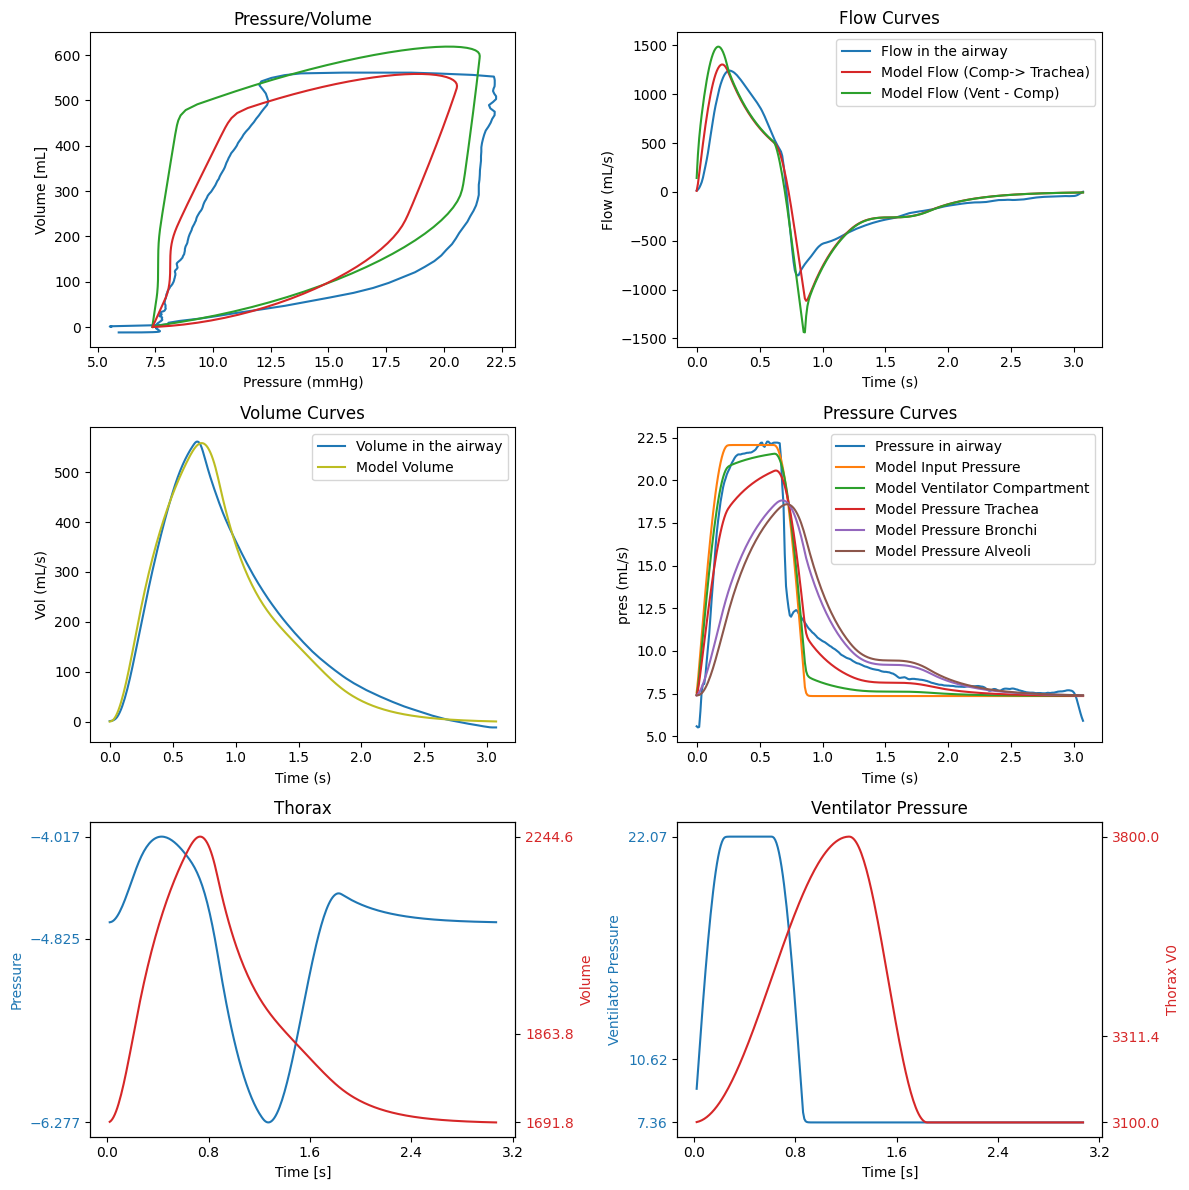

In [2]:
import numpy as np
import modelGenerator
import models
import time
import jax
import jax.numpy as jnp
import HDF5API
import matplotlib.pyplot as mpl
import matplotlib.gridspec as gridspec
import plots

from scipy.optimize import minimize

#███    ███  ██████  ██████  ███████ ██           ██████  ██████  ███    ██ ███████     ███████ ████████ ██    ██  ██████ ████████ 
#████  ████ ██    ██ ██   ██ ██      ██          ██      ██    ██ ████   ██ ██          ██         ██    ██    ██ ██         ██    
#██ ████ ██ ██    ██ ██   ██ █████   ██          ██      ██    ██ ██ ██  ██ █████       ███████    ██    ██    ██ ██         ██    
#██  ██  ██ ██    ██ ██   ██ ██      ██          ██      ██    ██ ██  ██ ██ ██               ██    ██    ██    ██ ██         ██    
#██      ██  ██████  ██████  ███████ ███████      ██████  ██████  ██   ████ ██          ███████    ██     ██████   ██████    ██    


def modelStructureAndParameters(gasExchange=True,control=True,dcComponent=0.0,amplitude=0.0,E_minThx=0.005):

    simulationParameters = {
        'dt': 0.01, # sets the integration step duration, the output is always 0.01 step
    }
    
    # Used to name the prefixes for naming of variables in the model
    prefixes = {
        'flow': 'Q_',
        'pressure': 'P_',
        'resistor': 'R_',
        'capacitor': 'C_',
        'volume': 'V_',
    }

    modelSwitches = {
        'gasExchange': gasExchange,
        'control': control,
    }

    # Not in use yet. if you need to change the total volume go to the capacitors y0 instead
    params = {
        'totalBloodVolume' : 4000.0, # Total Blood Volume not in use yet
        'totalLungVolume' : 2000.0,  # mL
        'airViscosity': modelGenerator.pa2mmHg(1.81e-5),  # kg/(m*s)  Pa*s (converted to mmHg)
        'bloodViscosity': modelGenerator.pa2mmHg(3.5e-3), # kg/(m*s)  Pa*s (converted to mmHg)
    }

    # To go to ventilator mode make the dcComponent and amplitude different from 0 and the Thorax elastances constant
    ventilatorParams = {
        'inputName': 'Ventilator',
        #'dcComponent': 12.0,  # baseline prassure mmHg
        #'amplitude': 7.0,  # breath amplitude mmHg
        'dcComponent': dcComponent,  # baseline prassure mmHg
        'amplitude': amplitude,  # breath amplitude mmHg
        'I': 1,
        'E': 4,
        'slopeFraction': 0.4,
    }

    # Names for the nodes to use in the model
    compartmentNames = ['Lt', 'Lb', 'La', 'Atm', 'Ven', 'Plr', 'Vc']

    ############################################### Connectivity Matrix  ####################################################
    
    #                               Lt Lb La Atm Ven Thx Vc
    connectivityMatrix = np.array([ 
                                    0, 1, 0,  0,  0,  0,  0,   # Lt
                                    0, 0, 1,  0,  0,  0,  0,   # Lb
                                    0, 0, 0,  0,  0,  0,  0,   # La
                                    0, 0, 0,  0,  0,  0,  0,   # Atm
                                    0, 0, 0,  0,  0,  0,  1,   # Ven
                                    0, 0, 0,  0,  0,  0,  0,   # Thx
                                    1, 0, 0,  0,  0,  0,  0,   # Vc
                                    ]).reshape(7, 7)


    ############################################### Resistor Parameters  ####################################################
    # Reisitors parameters (Names and number of resistors should be calculated by the connectivityMatrix) 
    resistorNames = ['VcLt', 'LtLb', 'LbLa', 'VenVc']

    #                                     R       L       y0  type
    resistorParamsMatrix = np.array([   0.002, 0.00100, 0.000, 1,  # VenLt
                                        0.004, 0.00000, 0.000, 1,  # LtLb
                                        0.001, 0.00000, 0.000, 1,  # LbLa
                                        0.001, 0.00000, 0.000, 1,  # LbLa
                                        ]).reshape(4, 4)
    

    ############################################### Capacitor Parameters  ####################################################
    #                                      C       V0     Emax    Emin   Trise    y0   type
    capacitorsParamsMatrix = np.array([ 0.5000, 75.000, 0.0000, 0.0000, 0.0000, 75.210, 2,  # Lt ####
                                        1.0000, 75.000, 0.0000, 0.0000, 0.0000, 75.780, 2,  # Lb ####
                                        50.000, 1000.0, 0.0000, 0.0000, 0.0000, 1325.7, 2,  # La ####
                                        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 5,  # Atm
                                        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 7,  # Ven
                                        300.00, 3500.0, 3800.0, 3100.0, 0.0000, 755.59, 4,  # Thx
                                        5.0000, 200.000, 0.0000, 0.0000, 0.0000, 75.210, 2,  # Vc ####
                                        ]).reshape(7, 7)
  
    ############################################### Pressure Bias Map  ####################################################    
    #                                      Lt Lb La Atm  Ven
    connectivityPresBiasMatrix = np.array([ 0, 0, 0,  0,  0,  0,  0,   # Lt
                                            0, 0, 0,  0,  0,  0,  0,   # Lb
                                            0, 0, 0,  0,  0,  0,  0,   # La
                                            1, 0, 0,  1,  1,  1,  1,   # Atm
                                            0, 0, 0,  0,  0,  0,  0,   # Ven
                                            0, 1, 1,  0,  0,  0,  0,   # Thx
                                            0, 0, 0,  0,  0,  0,  0,   # Vc
                                    ]).reshape(7 ,7)

    ############################################### Region Volume Map  ####################################################
    #                                       Lt Lb La Atm Ven
    connectivityRegionVolMatrix = np.array([ 
                                            0, 0, 0,  0,  0,  0,  0,   # Lt
                                            0, 0, 0,  0,  0,  0,  0,   # Lb
                                            0, 0, 0,  0,  0,  0,  0,   # La
                                            0, 0, 0,  0,  0,  0,  0,   # Atm
                                            0, 0, 0,  0,  0,  0,  0,   # Ven
                                            0, 1, 1,  0,  0,  0,  0,   # Thx
                                            0, 0, 0,  0,  0,  0,  0,  # Vc
                                    ]).reshape(7,7)


    ############################################### Membrane Resisros Map Map  ############################################
    #                                           Lt Lb La Atm Ven
    connectivityMemResistorsMatrix = np.array([ 
                                            0, 0, 0,  0,  0,  0,  0,   # Lt
                                            0, 0, 0,  0,  0,  0,  0,   # Lb
                                            0, 0, 0,  0,  0,  0,  0,   # La
                                            0, 0, 0,  0,  0,  0,  0,   # Atm
                                            0, 0, 0,  0,  0,  0,  0,   # Ven
                                            0, 0, 0,  0,  0,  0,  0,   # Thx
                                            0, 0, 0,  0,  0,  0,  0,   # Thx
                                    ]).reshape(7,7)

    ############################################### Cycles and Durations  #################################################

    cycles = ['RC','RCLa']
    #cyclesDuration = [0.9561, 2.8685]
    cyclesDuration = [3.08,3.08]
    #                                    Lt Lb La Atm Ven Thx
    cyclesDistributionMatrix = np.array([
                                        0, 0, 0,  0,  1, 0, 0,  # RC
                                        0, 0, 0,  0,  0, 1, 0,  # RCLa
                                    ]).reshape(2, 7)
    
    ############################################### Pressure Bias Map  ####################################################

    # Regions of different gas concentrations
    gasRegions = ['Atmosphere','Alveoli']
    # Gas species to consider
    gases = ['O2','C2','N2']

    # Gases partial pressures by region
    #                                O2      C2    N2    Total state
    gasPartialPressures = np.array([145.0, 7.000, 608.0, 760.0,  1,  # Atmosphere
                                    87.00, 40.00, 608.0, 760.0,  1,  # Alveoli
                                    81.60, 40.00, -1.00, 760.0,  2,  # Arterial
                                    71.50, 46.00, -1.00, 760.0,  2,  # Venous
                                    30.00, 50.00, -1.00, 760.0,  2,  # Tissues
                                ]).reshape(5, 5)

    # Membrane Reisitors parameters (Names and number of resistors should be calculated by the connectivityMemResistorsMatrix) 
    memResistorNames = ['O2_CpLa', 'C2_CpLa', 'O2_CsTiss', 'C2_CsTiss']
    #                                     R       L       y0  type
    resistorMemParamsMatrix = np.array([3.000/6, 0.00000, 0.000, 1,  # CpLa_O2
                                        1.200/6, 0.00000, 0.000, 1,  # CpLa_C2
                                        3.000/6, 0.00000, 0.000, 1,  # CsTiss_O2
                                        1.200/6, 0.00000, 0.000, 1,  # CsTiss_C2
                                    ]).reshape(4, 4)

    # Region connbectivity with the nodes for partial pressure distribution
    #                                   Lt Lb La Atm Ven
    gasDistributionMatrix = np.array([  1, 1, 0,  1,  1, 1, 1,  # Atmosphere
                                        0, 0, 1,  0,  0, 0, 0,  # Alveoli
                                    ]).reshape(2, 7)
    
    ############################################### Controllers  ##########################################################
    #                      period  varName varInt Type 
    integrators = np.array([
                    ]).reshape(0, 0)
    
    #                 AverageVar  ofVar    AtmPress Period type
    averages = np.array([
                    ]).reshape(0, 0)
    
    #                       TargetVar ToCtrllVar TargetVal MinVal MaxVal  Kp    Kd  type
    controllers = np.array([ #'a_As',   'R_AsCs',   90.0,    0.20,  2.00,  0.01, 3.0,  0,  # As
                             #'a_Ap',   'R_ApCp',   20.0,    0.01,  0.60,  0.01, 3.0,  0,  # Ap
                             #'a_COl',  'E_C_Hl',   92.0,    0.02,  40.0,  0.01, 3.0,  1,  # E_Hl
                             #'a_COr',  'E_C_Hr',   92.0,    0.02,  20.0,  0.01, 3.0,  1,  # E_Hr
                             #'V_La',   'C_La',    2000.0,   500.0,  55.0, 0.006,  3.0,  2,  # C_La
                             #'a_VLa',   'C_La',    1500.0,   75.0,  250.0, 0.004,  3.0,  2,  # C_La
                        ]).reshape(0, 8)

    modelStructure = {
            'prefixes': prefixes,
            'modelSwitches': modelSwitches,
            'params': params,
            'ventilatorParams': ventilatorParams,
            'compartmentNames': compartmentNames,
            'connectivityMatrix': connectivityMatrix,
            'resistorNames': resistorNames,
            'resistorParamsMatrix': resistorParamsMatrix,
            'capacitorsParamsMatrix': capacitorsParamsMatrix,
            'connectivityPresBiasMatrix': connectivityPresBiasMatrix,
            'connectivityRegionVolMatrix': connectivityRegionVolMatrix,
            'connectivityMemResistorsMatrix': connectivityMemResistorsMatrix,
            'gasRegions': gasRegions,
            'gases': gases,
            'gasPartialPressures': gasPartialPressures,
            'memResistorNames': memResistorNames,
            'resistorMemParamsMatrix': resistorMemParamsMatrix,
            'gasDistributionMatrix': gasDistributionMatrix,
            'cycles': cycles,
            'cyclesDuration': cyclesDuration,
            'cyclesDistributionMatrix': cyclesDistributionMatrix,
            'simulationParameters': simulationParameters,
            'averages': averages,
            'integrator': integrators,
            'controllers': controllers,
        }
    
    return modelStructure


def runSimulation(states, cpModel, runTime, totalRunsToIgnore, totalRuns, pressureRes, runsRes):
    trun = time.time()
    # Create the model object with the parameters and the equations to be solved by JAX

    ###############################################################
    # Second run to allow the system to stalibilse
    if totalRunsToIgnore > 0:
        pressureRes, runsRes, trun, states = models.runSolver(
                cpModel, 
                states, 
                structures['modelStructure']['simulationParameters'],
                pressureRes, 
                runsRes, 
                trun, 
                totalRunsToIgnore, 
                runTime, 
                save = False, 
                printTime = False
            )
    ###############################################################
    # TODO add results to HDF5 file
    # Third run to get the results
    pressureRes, runsRes, trun, states = models.runSolver(
            cpModel, 
            states, 
            structures['modelStructure']['simulationParameters'],
            pressureRes, 
            runsRes, 
            trun, 
            totalRuns, 
            runTime, 
            save = True, 
            printTime = False
        )

    return pressureRes, runsRes, trun, states

def simplePlot(results,totalTime,sampPeriod,atmPressure,toIgone):
    t = np.arange(0, totalTime, sampPeriod)
    fig = mpl.figure(figsize=(12, 12))
    grid = gridspec.GridSpec(3, 2, figure=fig)

    ax1 = fig.add_subplot(grid[0, 0])
    ax1.plot(results['pressure'][toIgone:],results['volume'][toIgone:])
    ax1.plot(results['P_Vc'][toIgone:]-atmPressure, np.cumsum(results['Q_VenVc'][toIgone:]*1e-2), color='tab:green')
    ax1.plot(results['P_Lt'][toIgone:]-atmPressure, np.cumsum(results['Q_VcLt'][toIgone:]*1e-2), color='tab:red')
    ax1.set_xlabel('Pressure (mmHg)')
    ax1.set_ylabel('Volume [mL]')
    ax1.set_title('Pressure/Volume')

    ax2 = fig.add_subplot(grid[0, 1])
    ax2.plot(t[toIgone:],results['flow'][toIgone:], label = 'Flow in the airway', color='tab:blue')
    ax2.plot(t[toIgone:],results['Q_VcLt'][toIgone:], label = 'Model Flow (Comp-> Trachea)', color='tab:red')
    ax2.plot(t[toIgone:],results['Q_VenVc'][toIgone:], label = 'Model Flow (Vent - Comp)', color='tab:green')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Flow (mL/s)')
    ax2.set_title('Flow Curves')
    ax2.legend()

    # np.save('Q_expt.npy', results['flow'])    
    # np.save('Q_model.npy', results['Q_VenLt'])   


    totVol = results['V_La'][toIgone:] + results['V_Lt'][toIgone:] + results['V_Lb'][toIgone:]
    ax3 = fig.add_subplot(grid[1, 0])
    #ax3.plot(t[toIgone:],results['Q_LtLb'][toIgone:])
    ax3.plot(t[toIgone:],results['volume'][toIgone:], label = 'Volume in the airway', color='tab:blue')
    ax3.plot(t[toIgone:],totVol- min(totVol), label = 'Model Volume', color='tab:olive') 
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Vol (mL/s)')
    ax3.set_title('Volume Curves')
    ax3.legend()

    ax4 = fig.add_subplot(grid[1, 1])   
    ax4.plot(t[toIgone:],results['pressure'][toIgone:], label = 'Pressure in airway', color='tab:blue')
    ax4.plot(t[toIgone:],results['P_Ven'][toIgone:]- atmPressure, label = 'Model Input Pressure', color='tab:orange')  
    ax4.plot(t[toIgone:],results['P_Vc'][toIgone:]- atmPressure, label = 'Model Ventilator Compartment', color='tab:green')  
    ax4.plot(t[toIgone:],results['P_Lt'][toIgone:]- atmPressure, label = 'Model Pressure Trachea', color='tab:red')
    ax4.plot(t[toIgone:],results['P_Lb'][toIgone:]- atmPressure, label = 'Model Pressure Bronchi', color='tab:purple')
    ax4.plot(t[toIgone:],results['P_La'][toIgone:]- atmPressure, label = 'Model Pressure Alveoli', color='tab:brown')    
    #ax4.plot(t[toIgone:],results['Q_LbLa'][toIgone:])
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('pres (mL/s)')
    ax4.set_title('Pressure Curves')
    ax4.legend()

    ##################################################################################################################################
    results['V_Plr'] = results['V_Lb'] + results['V_La']
    ax = fig.add_subplot(grid[2, 0])
    plots.buildLeftRightAxisIndependentScales(ax,results,'P_Plr', 'V_Plr', 'Thorax','Pressure','Volume','tab:blue','tab:red',atmPressure,t)
    ax.set_xlabel('Time [s]')
    
    ##################################################################################################################################
    results['uVol'] = plots.calculateThoraxUnstressedVolume(modelObjects,results)
    ax = fig.add_subplot(grid[2, 1])
    plots.buildLeftRightAxisIndependentScales(ax,results,'P_Ven', 'uVol', 'Ventilator Pressure','Ventilator Pressure','Thorax V0','tab:blue','tab:red',atmPressure,t)
    ax.set_xlabel('Time [s]')
    



    mpl.tight_layout()
    mpl.show()

def plotData(results, atmPressure):

    t = np.arange(len(results['pressure']))
    #'''
    # Attempt to recreate the volume from the flow in the trachea. There must be a reset of volume on the ventilator triggered every breath
    flowadjusted = results['flow']* 0.01
    newFlow = np.zeros(len(flowadjusted))
    for i in range(len(flowadjusted) - 2):
        newFlow[i] = flowadjusted[i+2]

    newFlow[0] = results['volume'][0]
    integratedFlow = np.cumsum(newFlow)
    #'''

    Q_VenLt = results['Q_VenLt']* 0.01
    newFlow = np.zeros(len(Q_VenLt))
    for i in range(len(Q_VenLt) - 2):
        newFlow[i] = Q_VenLt[i+2]

    newFlow[0] = results['V_La'][0]- min(results['V_La'])
    Q_VenLt = np.cumsum(newFlow)

    fig = mpl.figure(figsize=(15, 6))
    grid = gridspec.GridSpec(3, 2, figure=fig)

    ax_left = fig.add_subplot(grid[:, 0])
    ax_left.set_title('Pressure-Volume Curves')
    ax_left.plot(results['pressure'], results['volume'], label='PV_File', color='k')
    ax_left.plot(Q_VenLt,results['P_Ven']- atmPressure, label='PV_calculated', color='b')
    ax_left.legend()

    ax_right1 = fig.add_subplot(grid[0, 1])
    ax_right1.set_title('Pressure Curve')
    ax_right1.plot(t,results['pressure'], label='Pres File', color='k')
    ax_right1.plot(t,results['P_Ven']- atmPressure, label='P_Ven', color='r')
    ax_right1.plot(t,results['P_Lt']- atmPressure, label='P_Lt', color='b')
    ax_right1.plot(t,results['P_La']- atmPressure, label='P_La', color='g')
    ax_right1.legend()

    ax_right2 = fig.add_subplot(grid[1, 1])
    ax_right2.set_title('Volume Curve')
    ax_right2.plot(t,results['volume'], label='Vol File', color='k')
    #ax_right2.plot(t,np.cumsum(results['Q_VenLt'])*0.01, label='integrated flow', color='b')
    ax_right2.plot(t,Q_VenLt, label='integrated flow', color='b')
    ax_right2.plot(t,integratedFlow, label='int flow File', color='y')
    ax_right2.plot(t,results['V_La']- min(results['V_La']), label='V_La', color='g')
    ax_right2.legend()

    ax_right3 = fig.add_subplot(grid[2, 1])
    ax_right3.set_title('Flow Curve')
    ax_right3.plot(t,results['flow'], label='Flow File', color='k')
    ax_right3.plot(t,results['Q_VenLt'], label='Q_VenLt', color='b')
    ax_right3.plot(t,results['Q_LbLa'], label='Q_LbLa', color='g')
    ax_right3.legend()

    ax_right3.set_xlabel('Time [s]')

    mpl.tight_layout()
    mpl.show()


def RunModel(states,x, modelObjects, runTime, totalRunsToIgnore, totalRuns, pressureRes, runsRes):
    # x: unknown parameters
    #Put Jun code here to manipulate the following States:
    states['R_VcLt'] = x[0] #5.0                                    
    states['R_LtLb'] = x[1] #7.0
    states['R_LbLa'] = x[2] #3.0
    states['R_VenVc'] = x[3]
    
    states['C_Vc'] = x[4]
    states['C_Lt'] = x[5] #0.5
    states['C_Lb'] = x[6] #1.0
    states['C_La'] = x[7] #1000.0
    ############################################################


    pressureRes, runsRes, trun, states = runSimulation(states, modelObjects, runTime=runTime, totalRunsToIgnore=totalRunsToIgnore, totalRuns=totalRuns, pressureRes={}, runsRes={})
    results = pressureRes | runsRes
    
    return results['Q_VenVc']

'''
███    ███  █████  ██ ███    ██ 
████  ████ ██   ██ ██ ████   ██ 
██ ████ ██ ███████ ██ ██ ██  ██ 
██  ██  ██ ██   ██ ██ ██  ██ ██ 
██      ██ ██   ██ ██ ██   ████
'''
t0 = time.time()


## Example on how to read the data from the hdf5 file1 ###########################

#files = ['S5_1','S5_2','S1_1','S1_2','S4_1','S4_2','S3_1','S3_2','S6_1','S6_2','S7_1','S7_2','S9_1','S9_2']
files = ['S1_2']
t0 = time.time() 
#################################################################################

for file in files:
    pressure,volume,flow,startOfBreathCycle = HDF5API.getHdf5Data(file)

    startOfBreath=startOfBreathCycle.astype(np.int32)
    breathIdxs = startOfBreath[3,0] - startOfBreath[2,0]
    totalBreathTime = breathIdxs * 0.01
    print(totalBreathTime)
    pressure = pressure[startOfBreath[2,0]:startOfBreath[3,0]]
    flow = flow[startOfBreath[2,0]:startOfBreath[3,0]]
    volume = volume[startOfBreath[2,0]:startOfBreath[3,0]]

    Exptflow = flow*16.6667;

    with jax.default_device(jax.devices("cpu")[0]):
        jax.config.update("jax_enable_x64", True)

        runTime = 3.08
        #runTime = 1
        totalRunsToIgnore = 1
        totalRuns = 1
        totalTime = runTime*(totalRuns)
        sampPeriod = 0.01
        
        PEEP = 10* 0.735559
        AMP = 20* 0.735559

        #PEEP = 0.0
        #AMP = 0.0
        
        modelStructure = modelStructureAndParameters(gasExchange=False,control=True,dcComponent=PEEP,amplitude=AMP)
        modelStructure['capacitorsParamsMatrix'][4,6] = 6 # Type 7 is the read from file -> 'pressure equation'
        modelStructure['ventilatorPressure'] = tuple(np.transpose(np.squeeze((pressure * 0.735559) + 760.0)))


    #                       TargetVar ToCtrllVar TargetVal MinVal MaxVal  Kp    Kd  type
        modelStructure['controllers'] = np.array([ 
                            #'V_La',  'C_La',   400.0,    0.010,  1000.0,  0.02, 3.0,  0,
                            ]).reshape(0, 8)
        
        
        
        states, modelObjects, structures = modelGenerator.modelInit(modelStructure)

        cpModel = models.CardioPulmonaryModel(states, modelObjects)   
        
        # Ventilator Cycle
        offset = 0
        states['RC'] = 3.08
        states['triggerRC'] = 3.08 + offset
        states['timerRC'] = offset
        # Thorax Cycle
        states['RCLa'] = 3.08
        states['e_C_Plr'] = 3100
        states['E_C_Plr'] = 3800 #3800
        
        
        pressureRes, runsRes, trun, states = runSimulation(states, cpModel, runTime=runTime, totalRunsToIgnore=totalRunsToIgnore, totalRuns=totalRuns, pressureRes={}, runsRes={})
        results = pressureRes | runsRes

        results['pressure'] = pressure * 0.735559
        results['volume'] = volume
        results['flow'] = flow * 16.6667 #converts L/min to mL/s
        # cpModel = models.CardioPulmonaryModel(states, modelObjects)   
        # for i in range(1):
        #     print(i)
        #     results1,states1 = JunCode(states, cpModel, runTime, totalRunsToIgnore, totalRuns)

        atmPressure = states['P_Atm']
        # results1['pressure'] = pressure  * 0.735559
        # results1['flow'] = flow  * 16.6667
        # results1['volume'] = volume
        # # simplePlot(results1,totalTime,sampPeriod,atmPressure,0)
               
    simplePlot(results,totalTime,sampPeriod,atmPressure,0)



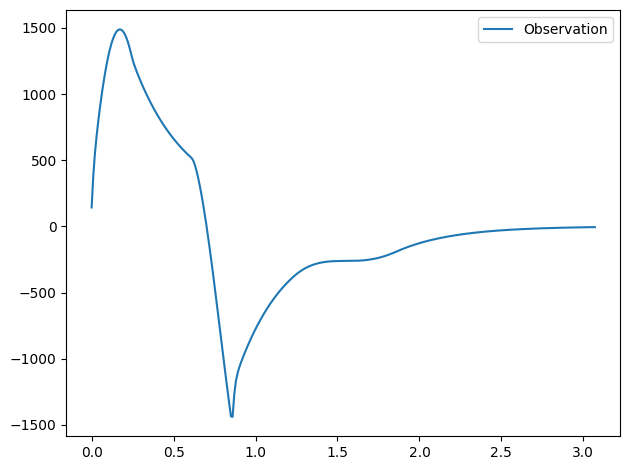

In [18]:
### observations computed via equations
obs = results['Q_VenVc']
t = np.arange(len(obs))
mpl.plot(t/100,obs, label='Observation')

mpl.legend()
mpl.tight_layout()
mpl.show()


In [4]:
import functools as ft
import math as math
import random
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy
import matplotlib.cm as cm


In [5]:
# Function to run the model given an input parameter array
def sim(x):
    runRes = RunModel(states,x,cpModel, runTime, totalRunsToIgnore, totalRuns, pressureRes, runsRes)
    return(runRes)

When the simulator outputs a curve and we are only able to observe the value of the curve at fixed time points, the observation could be regarded as a special case of multi-dimensional output. For Manuel's model, the simulator outputs the flow from time 0 to time N/100. For each flow, we will get N observed values at fixed time points $1/100, \ldots,N/100$ denoted by $z_j(\boldsymbol{x}) = [z_{j,1}(\boldsymbol{x}),\ldots,z_{j,N}(\boldsymbol{x})]$ and then, for $S_j = [s_{j,1}(\boldsymbol{x}),\ldots,s_{j,N}(\boldsymbol{x})]$, have 
\begin{equation}
    s_{j,i} = \left[\left(V_{o,j}+V_{m,j}+V_{e,j}(\boldsymbol{x},\boldsymbol{\theta})\right)^{-1/2} (z_j(\boldsymbol{x}) - \mathbb{E}_j(\eta(\boldsymbol{x},\boldsymbol{\theta}))) \right]_{i} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0,1). %\Rightarrow 
    %Z_i = \frac{z_{i}-\eta(x)_{i}}{ \sqrt{\sigma_{me}+\sigma_{md}}} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0,1)
\end{equation},
where $V_{o,j}, V_{m,j}$ and $V_{e,j}$ are the variances associated with the observational, model discrepancy and Gaussian processes emulators. 
Hence, 
\begin{equation}\label{eq: implausibility}
    I_j(\boldsymbol{\theta},\boldsymbol{x}) = \sum_{i=1}^{N} s_{j,i}^2 \sim \chi^2 (N) \Rightarrow \frac{\sum_{i=1}^{N} s_{j,i}^2 - N} {\sqrt{2*N}} \overset{d}{\rightarrow} \mathcal{N}(0,1)
\end{equation}
since the freedom degree of $\chi^2$ distribution is much greater than 50. % $k>>50$.
We could treat this statistic as an implausibility measure for curves, and the threshold is still 3 since a standard normal distribution obviously follows the 3-$\sigma$ rule.


In [11]:
## Implausibility measure
md= 10**2 # model discrepancy
me= 10**2 # measurement error
def Imp(obs,m,var):
    N = len(obs)
    Diff = np.array(obs)-np.array(m)
    Cov = np.diag(np.repeat(md+me,N))+var
    I = abs(np.matmul(np.matmul(np.transpose(Diff), np.linalg.inv(Cov)),Diff)-N)/math.sqrt(2*N)
#     print('Implausible measure')
#     print(I)
    return(I)


In [12]:
###Gaussian process emulators
from scipy.stats import qmc
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, WhiteKernel
import pandas as pd

###initialization
n = 100 # number of samples at each level
w = 0

sample = pd.read_csv("samples1.csv")
D_x = np.asarray(sample)[:n,1:]

data= pd.read_csv("curves1.csv")
D_y = np.asarray(data)[:n,1:]

X_mean = D_x.mean(axis=0)
X_std = D_x.std(axis=0)
D_x = (D_x-X_mean)/X_std

###Perform PCA
pca = PCA(n_components=3)
pca.fit(D_y)
M = pca.components_ # PCA matrix 

###GP
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5, length_scale_bounds="fixed") 

Y = pca.transform(D_y)
gpr0 = GaussianProcessRegressor(kernel = kernel).fit(D_x, Y[:,0])
gpr1 = GaussianProcessRegressor(kernel = kernel).fit(D_x, Y[:,1])
gpr2 = GaussianProcessRegressor(kernel = kernel).fit(D_x, Y[:,2])

###define a new prediction function
def prediction(x_new):
    y_pre0, y_cov0 = gpr0.predict([x_new], return_cov=True)# x_new = new samples
    y_pre1, y_cov1 = gpr1.predict([x_new], return_cov=True)
    y_pre2, y_cov2 = gpr2.predict([x_new], return_cov=True)

    Y_pre = np.stack((y_pre0,y_pre1,y_pre2),axis=1)
    y_inverse = pca.inverse_transform(Y_pre)
    y_var = np.matmul(np.matmul(np.transpose(M),np.diag(np.array([y_cov0[0,0],y_cov1[0,0],y_cov2[0,0]]))),M)

    return(y_inverse[0,:],y_var)

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [13]:
# boundary
l_bounds = [0.001,0.002,0.004,0.001,1.5,1.5,3,50]
u_bounds = [0.01,0.02,0.04,0.01,3,3,6,1000]

###modified metropolis
def modmetro(nc,ns,d,z,Y):
    acc = 0
    q = np.zeros(d) # potential next position
    sd = np.sqrt(np.diag(np.cov(np.transpose(z[:,:,0])))) ###standard derivation
    #print(sd.shape)
    for j in range(nc):
        for m in range(ns):
            ### step 1
            for k in range(d):
                a = z[j,k,m]+ norm.rvs(0,sd[k],1)
                if l_bounds[k]<=a and a<=u_bounds[k]:
                    q[k] = a
                else:
                    q[k] = z[j,k,m]
            ###step 2 q belongs to F_L or not
            q_rev = (q - X_mean)/X_std 
            mean,var = prediction(q_rev)
            if Imp(obs,mean,var)<Y: ###responses
                z[j,:,m+1]=q
                acc = acc + 1
            else:
                z[j,:,m+1]=z[j,:,m]
    print(acc/(nc*ns))
    return(z)

In [14]:
### inner loop of HM, i.e., sus
def sus(obs,n):
    d = 8 #dimension of the input space
    YF = 3 #critical threshold (gx>=YF)
    n = n #number of samples per level
    p = 0.1 #level probability
    nc = int(n*p) #number of Markov chains
    ns = int((1-p)/p) #number of states in each chain
    L = 0 # zero level
    Lmax = 100 # define the possible maximum of number of levels
    Xs = np.zeros((n,d,Lmax)) #samples for different levels
    nF = np.zeros(Lmax) # number of failure samples
    ys = np.zeros((Lmax,n)) # responses
    Ys = np.zeros(Lmax)# intermediate threshold
    zs = np.zeros((nc,d,ns+1)) # seeds
    for k in range(d):
        Xs[:,k,0] = np.random.uniform(l_bounds[k],u_bounds[k],n) ### samples for zero level
    for i in range(n):
        x_rev = (Xs[i,:,L]-X_mean)/X_std
        mean,var = prediction(x_rev)
        ys[L, i] = Imp(obs=obs,m=mean,var=var)
        if ys[0,i]<YF: # whether it falls in failure domain
            nF[0]=nF[0]+1

    #responses= pd.read_csv("responses.csv")
    #ys[0,:]=np.transpose(np.asarray(responses)[:200,1])
    
    while (nF[L]/n)<p and L<=11:
        #index = [0]
        L=L+1 # next conditional level is needed
        ###threshold
        y_now = ys[L-1,:] 
        ind = sorted(range(len(y_now)), key=lambda k: y_now[k])# original index of descending responses
        ys[L-1,:] = ys[L-1,ind] #renumbered responses
        Xs[:,:, L-1] = Xs[ind,:,L-1] # renumbered samples
        Ys[L-1] = (ys[L-1,nc-1]+ys[L-1,nc])/2 #L^th intermediate threshold
        zs[:,:,0] = Xs[range(0,nc),:, L-1] # seeds of Markov chain
        print('L = ', L)
        print('intermediate threshold:',Ys[L-1])
        #mutation (modmetro)
        zs = modmetro(nc,ns,d,z=zs,Y=Ys[L-1])
        for j in range(1,nc+1):
            for m in range(1,ns+2):
                Xs[(j-1)*(ns+1)+m-1,:,L]=zs[j-1,:,m-1]### update L-th level samples
        zs = np.zeros((nc,d,ns+1))  
        for i in range(n):
            x_rev = (Xs[i,:,L]-X_mean)/X_std
            mean,var = prediction(x_rev)
            ys[L, i] = Imp(obs=obs,m=mean,var=var)
            if ys[L, i]<YF:
                nF[L]=nF[L]+1
                #index.append(i)
                
    #Xfin = Xs[index[1:],:,L]
    #return(Xfin)
    return(Xs[:,:,L])

In [15]:
### outter loop of HM
nS = 0
p = 0.1
YF = 3
while (nS/n)<p and w<11:
    print(w)
    w = w + 1 ##update wave
    rs = np.empty(n) # responses
    nS = 0 # the number of successful samples fall in the true non-implausible domain
    
    D_x_pre = sus(obs,n)
    ### update training data sets and emulators
    D_y_new = np.empty((n,308))

    for i in range(n):
        D_y_new[i,:] = sim(D_x_pre[i,:])
        rs[i] = Imp(obs=obs,m=D_y_new[i,:],var = 0)
        print('Implausible measure')
        print(rs[i])
        if rs[i]<YF:
            nS = nS+1
    print(nS)
    
    D_x_new = (D_x_pre - X_mean)/X_std 
    D_x = np.concatenate((D_x, D_x_new))
    D_y = np.concatenate((D_y, D_y_new))
    na = np.isnan(D_y).any(axis=1)
    D_y = D_y[~na]
    D_x = D_x[~na]
    print(D_x.shape)
    
    ###Perform PCA
    pca = PCA(n_components=3)
    pca.fit(D_y)
    M = pca.components_ # PCA matrix 

    ###GP
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5, length_scale_bounds="fixed") 

    Y = pca.transform(D_y)
    gpr0 = GaussianProcessRegressor(kernel = kernel).fit(D_x, Y[:,0])
    gpr1 = GaussianProcessRegressor(kernel = kernel).fit(D_x, Y[:,1])
    gpr2 = GaussianProcessRegressor(kernel = kernel).fit(D_x, Y[:,2])
    
    ###define a new prediction function
    def prediction(x_new):
        y_pre0,y_cov0 = gpr0.predict([x_new], return_cov=True)# x_new = new samples
        y_pre1,y_cov1 = gpr1.predict([x_new], return_cov=True)
        y_pre2,y_cov2 = gpr2.predict([x_new], return_cov=True)

        Y_pre = np.stack((y_pre0,y_pre1,y_pre2),axis=1)
        y_inverse = pca.inverse_transform(Y_pre)
        y_var = np.matmul(np.matmul(np.transpose(M),np.diag(np.array([y_cov0[0,0],y_cov1[0,0],y_cov2[0,0]]))),M)
        
        return(y_inverse[0,:],y_var)
    

0
L =  1
intermediate threshold: 2902.96804286898
0.5555555555555556
L =  2
intermediate threshold: 2901.4973931143622
0.5333333333333333
L =  3
intermediate threshold: 2899.168422961126
0.5222222222222223
L =  4
intermediate threshold: 2897.977941638953
0.36666666666666664
L =  5
intermediate threshold: 2897.3951031197876
0.26666666666666666
L =  6
intermediate threshold: 2897.1490078224924
0.43333333333333335
L =  7
intermediate threshold: 2897.062961241319
0.5555555555555556
L =  8
intermediate threshold: 2897.0127247402897
0.3111111111111111
L =  9
intermediate threshold: 2896.99241132683
0.32222222222222224
L =  10
intermediate threshold: 2896.9806627089015
0.37777777777777777
L =  11
intermediate threshold: 2896.9702796710117
0.35555555555555557
L =  12
intermediate threshold: 2896.9651783724394
0.43333333333333335
Implausible measure
6996.818450237932
Implausible measure
6996.818450237932
Implausible measure
6996.818450237932
Implausible measure
6996.818450237932
Implausible mea

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


L =  1
intermediate threshold: 3231.6480993839546
0.4888888888888889
L =  2
intermediate threshold: 3229.976643904466
0.4888888888888889
L =  3
intermediate threshold: 3228.982792611988
0.4222222222222222
L =  4
intermediate threshold: 3228.2517902886284
0.37777777777777777
L =  5
intermediate threshold: 3227.7770818047884
0.5444444444444444
L =  6
intermediate threshold: 3227.5790798477983
0.4111111111111111
L =  7
intermediate threshold: 3227.4946914851835
0.4
L =  8
intermediate threshold: 3227.434651189339
0.3888888888888889
L =  9
intermediate threshold: 3227.355547207024
0.45555555555555555
L =  10
intermediate threshold: 3227.314271615255
0.34444444444444444
L =  11
intermediate threshold: 3227.285539944539
0.5444444444444444
L =  12
intermediate threshold: 3227.249560956234
0.4444444444444444
Implausible measure
740.0516396935501
Implausible measure
1088.171497673967
Implausible measure
1088.171497673967
Implausible measure
1088.171497673967
Implausible measure
1088.17149767396

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


L =  1
intermediate threshold: 78.33856771089194
0.37777777777777777
L =  2
intermediate threshold: 75.63638919986145
0.13333333333333333
L =  3
intermediate threshold: 74.9146974408068
0.3333333333333333
L =  4
intermediate threshold: 74.33366801511511
0.2111111111111111
L =  5
intermediate threshold: 74.10621528823187
0.5111111111111111
L =  6
intermediate threshold: 73.89277260974069
0.43333333333333335
L =  7
intermediate threshold: 73.80702197274955
0.6666666666666666
L =  8
intermediate threshold: 73.70789713351078
0.5777777777777777
L =  9
intermediate threshold: 73.65072036043901
0.6555555555555556
L =  10
intermediate threshold: 73.61085848562558
0.6111111111111112
L =  11
intermediate threshold: 73.57797204867586
0.5333333333333333
L =  12
intermediate threshold: 73.55847182476269
0.5333333333333333
Implausible measure
6775.237340273648
Implausible measure
6822.182857540204
Implausible measure
6822.182857540204
Implausible measure
6702.115975032501
Implausible measure
6627.78

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


L =  1
intermediate threshold: 90.13058498745957
0.37777777777777777
L =  2
intermediate threshold: 88.21552547688634
0.14444444444444443
L =  3
intermediate threshold: 87.49019461227064
0.23333333333333334
L =  4
intermediate threshold: 86.97437686640714
0.12222222222222222
L =  5
intermediate threshold: 86.53091176171264
0.1111111111111111
L =  6
intermediate threshold: 86.2726142892342
0.14444444444444443
L =  7
intermediate threshold: 86.14861430570201
0.4444444444444444
L =  8
intermediate threshold: 85.94161488088041
0.4
L =  9
intermediate threshold: 85.82439416558012
0.5888888888888889
L =  10
intermediate threshold: 85.76050438919673
0.5333333333333333
L =  11
intermediate threshold: 85.71385619051111
0.5444444444444444
L =  12
intermediate threshold: 85.67554761518602
0.7888888888888889
Implausible measure
10997.965496179546
Implausible measure
11004.216884007465
Implausible measure
11005.318347355756
Implausible measure
11016.31673346334
Implausible measure
11006.23448368765

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


4
L =  1
intermediate threshold: 132.2532973076089
0.45555555555555555
L =  2
intermediate threshold: 128.80770504167754
0.26666666666666666
L =  3
intermediate threshold: 127.86513114360261
0.6333333333333333
L =  4
intermediate threshold: 127.06292694099115
0.43333333333333335
L =  5
intermediate threshold: 126.32051033724717
0.5111111111111111
L =  6
intermediate threshold: 125.56610282498382
0.5111111111111111
L =  7
intermediate threshold: 124.22259980643453
0.6111111111111112
L =  8
intermediate threshold: 121.69909373836998
0.4444444444444444
L =  9
intermediate threshold: 119.78602400302691
0.3888888888888889
L =  10
intermediate threshold: 118.88701705413297
0.24444444444444444
L =  11
intermediate threshold: 118.08747545624698
0.24444444444444444
L =  12
intermediate threshold: 117.38156331827788
0.36666666666666664
Implausible measure
3.786612942563671
Implausible measure
3.1836091424752837
Implausible measure
3.220235692174589
Implausible measure
22.84239309159931
Implausib

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


5
L =  1
intermediate threshold: 33.010847952104285
0.4111111111111111
L =  2
intermediate threshold: 30.356934457094773
0.17777777777777778
L =  3
intermediate threshold: 29.359912546800395
0.2777777777777778
L =  4
intermediate threshold: 28.565810903284202
0.13333333333333333
L =  5
intermediate threshold: 28.247974224318757
0.1
L =  6
intermediate threshold: 28.153834456442336
0.16666666666666666
L =  7
intermediate threshold: 28.044082581800414
0.8555555555555555
L =  8
intermediate threshold: 27.93085765350817
0.8222222222222222
L =  9
intermediate threshold: 27.87636700676255
0.6666666666666666
L =  10
intermediate threshold: 27.818594518674068
0.7666666666666667
L =  11
intermediate threshold: 27.769512539989687
0.5888888888888889
L =  12
intermediate threshold: 27.74263677482086
0.5888888888888889
Implausible measure
8633.653606242931
Implausible measure
8675.602233440333
Implausible measure
8688.609817268512
Implausible measure
8645.146870094715
Implausible measure
8686.77151

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


6
L =  1
intermediate threshold: 34.65584380852417
0.32222222222222224
L =  2
intermediate threshold: 32.085392089244564
0.5333333333333333
L =  3
intermediate threshold: 31.048812670503807
0.4888888888888889
L =  4
intermediate threshold: 30.708535229927765
0.5555555555555556
L =  5
intermediate threshold: 30.47541314511773
0.6444444444444445
L =  6
intermediate threshold: 30.34307780401615
0.5111111111111111
L =  7
intermediate threshold: 30.233546608626977
0.34444444444444444
L =  8
intermediate threshold: 30.162800140184693
0.5444444444444444
L =  9
intermediate threshold: 30.122576567386595
0.4777777777777778
L =  10
intermediate threshold: 30.087448193181636
0.4
L =  11
intermediate threshold: 30.0680485723228
0.5111111111111111
L =  12
intermediate threshold: 30.049385050378433
0.36666666666666664
Implausible measure
13544.34177043218
Implausible measure
13544.34177043218
Implausible measure
13544.34177043218
Implausible measure
13544.34177043218
Implausible measure
13548.584318

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


7
L =  1
intermediate threshold: 21.667224797074603
0.2777777777777778
L =  2
intermediate threshold: 19.945411475001773
0.18888888888888888
L =  3
intermediate threshold: 18.416799712501163
0.6111111111111112
L =  4
intermediate threshold: 16.0025078831211
0.4444444444444444
L =  5
intermediate threshold: 14.366498580182125
0.5444444444444444
L =  6
intermediate threshold: 12.294705447733335
0.4666666666666667
L =  7
intermediate threshold: 11.166481373785139
0.45555555555555555
L =  8
intermediate threshold: 10.34706509031207
0.4444444444444444
L =  9
intermediate threshold: 9.251796412267682
0.4444444444444444
L =  10
intermediate threshold: 8.352440250910671
0.4
L =  11
intermediate threshold: 7.828610105796827
0.5555555555555556
L =  12
intermediate threshold: 7.4002200033922865
0.24444444444444444
Implausible measure
3.121914688709175
Implausible measure
6.696347081324067
Implausible measure
6.696347081324067
Implausible measure
6.696347081324067
Implausible measure
6.69634708132

/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/juncheng/miniforge3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


We could observe that when our estimation approaches the observation for the first time (iteration 2 above also simulation 3 below), our corresponding Gaussian process emulator obtains a lot of particles close to the true value (and the boundtries since we did not set the boundtries appropriately) and then suddenly have some issues resulting in very high posterior variance. Similar issues in https://datascience.stackexchange.com/questions/31508/gaussian-process-regression-sudden-increase-of-the-predictions-variance

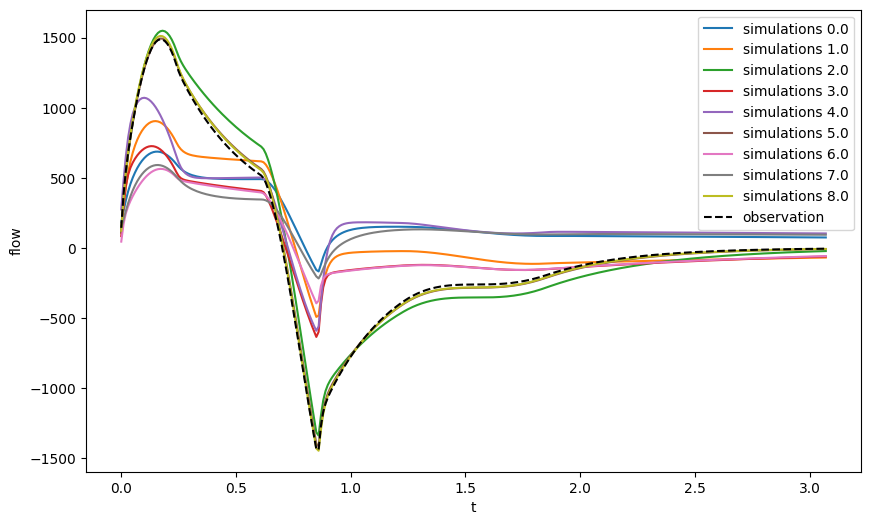

In [17]:
mpl.figure(figsize=(10,6))
D_x = D_x*X_std+X_mean
for i in range(int(D_x.shape[0]/n)):
    p = np.mean(D_x[int(i*n):int((i+1)*n),:],0) #points
    #print(p)
    simulation = RunModel(states,p, cpModel, runTime, totalRunsToIgnore, totalRuns, pressureRes, runsRes)
    #print(Imp(obs=obs,m=simulation,var = 0))
    mpl.plot(t/100,simulation, label = 'simulations %.1f' %i)
mpl.plot(t/100,obs , '--',label = 'observation',color = 'black')

mpl.xlabel('t')
mpl.ylabel('flow')
mpl.legend()
mpl.show()